## Data Analysis Raster Plots

#### Tracking Program single Fly Tracker

Data is exported to an CSV file


In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd 

%matplotlib notebook

### Selecting data set file 
- Import Columns: Frames, Seconds , x and y positions and LED
- Convert Frames to secods
- Select onset stim 

In [2]:
#Opening the data set file

#when run more than one time says list command is not applyable
from csv import reader
num_files = 20
flymotion_all = []
for i in range(num_files):
    folder_name = 'data_sens37_unamp/'
    file_name = '100718_Sens37_unamp_'+str(i+1)+'_fly0.csv'
    file = open(folder_name+file_name)
    read_file = reader(file)
    flymotion_all.append(list(read_file
                             ))

In [3]:
# analysis on one file
folder_name = 'data_sens37_unamp/'
file_name = '100718_Sens37_unamp_1_fly0.csv'
file1 = open(folder_name+file_name)
read_file1 = list(reader(file1))

In [4]:
# Data treatment 
def data_treatment(file):
    '''
    Select only columns: frames, time, x and y coordinates, and LED_lum and transform data into np_array
    Returns:1) data_array containing frames, time, x and y coordinates 
            2) LED_lum column
    '''
    fm_data = file[4:]  #Exclude first 4 rows containing unnecessary information
    fm_data_array = np.array(fm_data)  #transform data into np array
    data_array = fm_data_array[:, 0:4]  #select only frames,seconds and x,y position
    pixel_change = fm_data_array[2:,4].astype(np.int)  #pixel change stats in 2 in order to be aligned with the velocity
    LED_lum = fm_data_array[1:,8].astype(np.float)  #Select the LED colmumn to know where is the Red Light Stim
    return data_array, pixel_change, LED_lum

def frame_to_time(data_array, framerate=30.):
    frames = (data_array[1:, 0]).astype(np.float)   #transform array into float
    timepoints = frames/framerate
    return frames, timepoints

def LED_ON(LED_lum, frames, timepoints):
    '''
    Inform when stimulus is on with LED lum. change
    '''
    LED_diff = np.diff(LED_lum) 
    timepoints_LED = timepoints[1:]
    frames_LED = frames[1:]
    crimson_stim_time = timepoints_LED[np.greater(np.abs(LED_diff), 2.)] #look for the place where LED lum changed
    crimson_stim_frame = (frames_LED[np.greater(np.abs(LED_diff), 2.)]).astype(int)
    return crimson_stim_time, crimson_stim_frame

def pixel_per_mm(file):
    '''
    Calculate pixel per mm using arena size 
    '''
    arena_size_pixel = file[2][1]  #retrieve from excel the size of the arena in pixels
    arena_size_mm = 54
    ppm = int(arena_size_pixel) / int(arena_size_mm)  #pixel per mm
    return ppm  

def calculate_dist(data_array, ppm):
    x_coordinates = ((data_array[1:, 2]).astype(np.float))/ppm   #transform coordinates in pixels into mm
    y_coordinates = ((data_array[1:, 3]).astype(np.float))/ppm
    positions_array = np.vstack((x_coordinates, y_coordinates))
    distance_between_frames = np.sqrt(np.sum((np.diff(positions_array))**2, axis=0))
    cumulative_distance = np.cumsum(distance_between_frames)
    return x_coordinates, y_coordinates, positions_array,distance_between_frames, cumulative_distance

def calculate_velocity(distance_between_frames, framerate=30.):
    velocity = np.divide(distance_between_frames, (1/framerate))
    nvel = velocity.shape[0]
    return velocity


def stimulus_on_off_sec(LED_lum, frames, timepoints):
    crimson_stim_time, crimson_stim_frame = LED_ON(LED_lum, frames, timepoints)    
    stim_onset_frame =  crimson_stim_frame[0]
    stim_offset_frame = crimson_stim_frame[1]
    
    # analyse only a section of the total frames of 30 frames before crim. onset and 120 frames after crim. onset
    # set starting and point for plots
    start_point = stim_onset_frame - 30
    end_point = stim_onset_frame + 90
    return start_point, end_point


In [5]:
file = read_file1.copy()
data_array, pixel_change, LED_lum = data_treatment(file)
frames, timepoints = frame_to_time(data_array)
LED_diff = np.diff(LED_lum) 
timepoints_LED = timepoints[1:]
frames_LED = frames[1:]
crimson_stim_time = timepoints_LED[np.greater(np.abs(LED_diff), 2.)] #look for the place where LED lum changed 
crimson_stim_frame = (frames_LED[np.greater(np.abs(LED_diff), 2.)]).astype(int)
start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)

## Raster plots
Here we represent the different behaviours of the fly across time. The behaviours can be stoping (no forward velocity no pixel change), grooming (no forward velocity, only pixel change), and walking( forward velocity and pixel change)

In [18]:
data_array, pixel_change, LED_lum = data_treatment(read_file1)
ppm = pixel_per_mm(read_file1)
frames, timepoints = frame_to_time(data_array)
x_coordinates, y_coordinates, positions_array, distance_between_frames, cumulative_distance = calculate_dist(
    data_array, ppm)
velocity = calculate_velocity(distance_between_frames, framerate=30.)
crimson_stim_time, crimson_stim_frame = LED_ON(LED_lum, frames, timepoints)
dur_crimson = crimson_stim_time[1] - crimson_stim_time[0]
start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)
print (len(velocity))
print (len(pixel_change))

framerate=30 
frames_corrected = frames[1:]
frames_stim = frames_corrected[start_point:end_point]
velocity_trunc = velocity[start_point:end_point]
pixel_change_trunc = pixel_change[start_point:end_point]
time_axis = timepoints[start_point:end_point] - (crimson_stim_time[0])+(1/framerate)
print(crimson_stim_frame[0])

print (len(velocity_trunc))
print (len(pixel_change_trunc))

595
595
126
120
120


In [20]:
def classify_pxl_change(pxl_change, velocity):
    # creat array of behaviour category
    behav_cat_array = np.zeros(pxl_change.size)
    assert pxl_change.size == velocity.size

    for i in range(pxl_change.size):
        if pxl_change[i] >0:
            if velocity[i] > 1.4: 
                behav_cat_array[i]=1
            elif velocity[i] == 0:
                behav_cat_array[i]=2

        else:
            pass
    return behav_cat_array

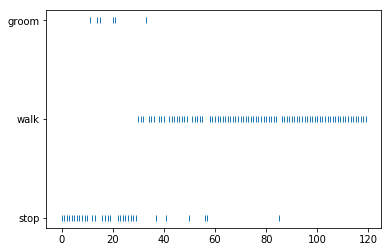

In [21]:
beh_cat_example = classify_pxl_change(pixel_change_trunc, velocity_trunc)
fig, ax = plt.subplots()
ax.plot(beh_cat_example, '|')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['stop', 'walk', 'groom'])
plt.show()

In [22]:
#Opening the data set file
# from csv import reader
num_files = 20
# flymotion_all = []
velocity_all = []
cum_distance_all = []
behaviour_classif_all = []

for i in range(num_files):
    folder_name = 'data_sens37_unamp/'
    file_name = '100718_Sens37_unamp_'+str(i+1)+'_fly0.csv'
    file = open(folder_name+file_name)
    read_file = list(reader(file))
    # preprocessing on the read_file
    data_array, pixel_change, LED_lum = data_treatment(read_file)
    ppm = pixel_per_mm(read_file)
    frames, timepoints = frame_to_time(data_array)
    x_coordinates, y_coordinates, positions_array, distance_between_frames, cumulative_distance = calculate_dist(
        data_array, ppm)
    start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)
    velocity = calculate_velocity(distance_between_frames, framerate=30.)#velocity values for each frame
    velocity_cropped = velocity[start_point:end_point] # we cut the velocity values 1 seconds before the stim and 4 seconds after
    pixel_change_cropped = pixel_change[start_point:end_point]
    velocity_all.append(velocity_cropped)
    
    behaviour_cat = classify_pxl_change(pixel_change_cropped,velocity_cropped)
    behaviour_classif_all.append(behaviour_cat)
    


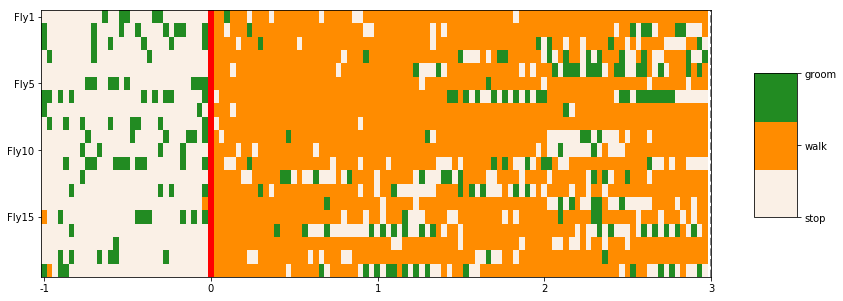

In [23]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
frame_start_stim = 30
frame_offset_analysis = 120
beh_cat_matrix = np.array(behaviour_classif_all)

fig,ax = plt.subplots(figsize=(12, 10))

#cmap = cm.get_cmap('jet',3)
cmap = ListedColormap(["linen","darkorange", "forestgreen"])

# tell imshow about color map so that only set colors are used
img = ax.imshow(beh_cat_matrix,cmap=cmap,interpolation='nearest')
ax.set_aspect(2.4)
ax.set_xticks(np.arange(0, 150, 30))
ax.set_xticklabels([-1, 0, 1, 2, 3,4])
ax.set_yticks(np.arange(0,20,5))
ax.set_yticklabels(['Fly1', 'Fly5', 'Fly10', 'Fly15'])
ax.axvline(x=frame_start_stim, color='red', lw=6)
ax.axvline(x=frame_offset_analysis, color='grey', lw=2, ls='--')

cbar_ax = fig.add_axes([0.95, 0.4, 0.05, 0.2])
# make a color bar
cbar = fig.colorbar(img, cax=cbar_ax, cmap=cmap, ticks=np.arange(3))
cbar.ax.set_yticklabels(['stop', 'walk', 'groom'])  # vertically oriented colorbar

plt.savefig('Rasterplot_sens37_unamp.svg')
plt.savefig('Rasterplot_sens37_unamp.png')

plt.show()

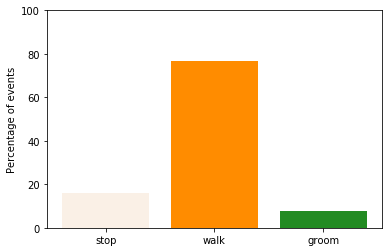

In [24]:
total_number_events = (frame_offset_analysis-frame_start_stim)*num_files
beh_cat_timechunk = beh_cat_matrix[:,frame_start_stim:frame_offset_analysis]
fig, ax = plt.subplots()
counts, edges = np.histogram(beh_cat_timechunk.ravel(), bins=[0,1,2,3])
ax.set_ylabel('Percentage of events')
ax.bar(np.arange(3), (counts/total_number_events)*100,color=("linen","darkorange", "forestgreen"))
ax.set_xticks([0, 1,2])
ax.set_xticklabels(['stop', 'walk', 'groom'])
ax.set_ylim([0, 100])

plt.savefig('HistRasterplot_sens37_unamp.svg')
plt.savefig('HistRasterplot_sens37_unamp.png')

plt.show()

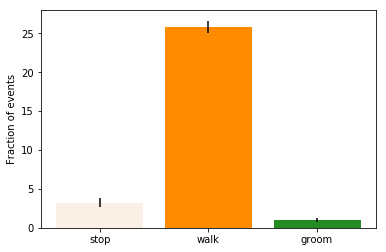

In [30]:
num_events_fly = (frame_offset_analysis-frame_start_stim)
num_categories = 3
beh_cat_timechunk = beh_cat_matrix[:,frame_start_stim:frame_offset_analysis]
frac_counts_cat_allflies = np.empty((num_files, num_categories))
for fly_index in range(num_files):
    counts_fly, edges = np.histogram(beh_cat_timechunk[fly_index, :], bins=[0,1,2,3])
    frac_counts_cat_allflies[fly_index, :] = counts_fly

sem_cat = np.std(frac_counts_cat_allflies, axis=0)/np.sqrt(num_files)
fig, ax = plt.subplots()
ax.bar(np.arange(3), np.mean(frac_counts_cat_allflies, axis=0), yerr=sem_cat,
       color=("linen","darkorange", "forestgreen"))
ax.set_xticks([0, 1,2])
ax.set_xticklabels(['stop', 'walk', 'groom'])
ax.set_ylabel('Fraction of events')

#plt.savefig('HistRasterplot_sens37_unamp.svg')
#plt.savefig('HistRasterplot_sens37_unamp.png')

plt.show()

import numpy
a=frac_counts_cat_allflies
numpy.savetxt("msbristles_unamp.csv", a, delimiter=",",fmt='%d')


#print (frac_counts_cat_allflies)
#print (sem_cat)

In [31]:
#print(frac_counts_cat_allflies)
beh_cat_matrix = np.array(behaviour_classif_all)
num_categories = 3
frac_counts_3sec = np.empty((num_files, num_categories))
for fly_index in range(num_files):
    counts_fly, edges = np.histogram(beh_cat_matrix[fly_index, :], bins=[0,1,2,3])
    frac_counts_3sec[fly_index, :] = counts_fly

sem_cat = np.std(frac_counts_3sec, axis=0)/np.sqrt(num_files)

walk_number = []
for i in range(len(frac_counts_3sec)):   #get counts for 
    walk=int(frac_counts_3sec[i][1])
    walk_number.append(walk)
print (walk_number)
sort_index = np.argsort(walk_number)
sort_index



[83, 73, 71, 63, 59, 84, 54, 86, 87, 70, 72, 62, 56, 62, 69, 73, 43, 79, 77, 58]


array([16,  6, 12, 19,  4, 13, 11,  3, 14,  9,  2, 10, 15,  1, 18, 17,  0,
        5,  7,  8])

In [32]:
#Opening the data set file
# from csv import reader
num_files = 20
# flymotion_all = []
velocity_all = []
cum_distance_all = []
behaviour_classif_all_ordered = []

for i in sort_index:
    folder_name = 'data_sens37_unamp/'
    file_name = '100718_Sens37_unamp_'+str(i+1)+'_fly0.csv'
    file = open(folder_name+file_name)
    read_file = list(reader(file))
    # preprocessing on the read_file
    data_array, pixel_change, LED_lum = data_treatment(read_file)
    ppm = pixel_per_mm(read_file)
    frames, timepoints = frame_to_time(data_array)
    x_coordinates, y_coordinates, positions_array, distance_between_frames, cumulative_distance = calculate_dist(
        data_array, ppm)
    start_point, end_point = stimulus_on_off_sec(LED_lum, frames, timepoints)
    velocity = calculate_velocity(distance_between_frames, framerate=30.)#velocity values for each frame
    velocity_cropped = velocity[start_point:end_point] # we cut the velocity values 1 seconds before the stim and 4 seconds after
    pixel_change_cropped = pixel_change[start_point:end_point]
    velocity_all.append(velocity_cropped)
    
    behaviour_cat = classify_pxl_change(pixel_change_cropped,velocity_cropped)
    behaviour_classif_all_ordered.append(behaviour_cat)
    
#print (behaviour_classif_all_ordered)

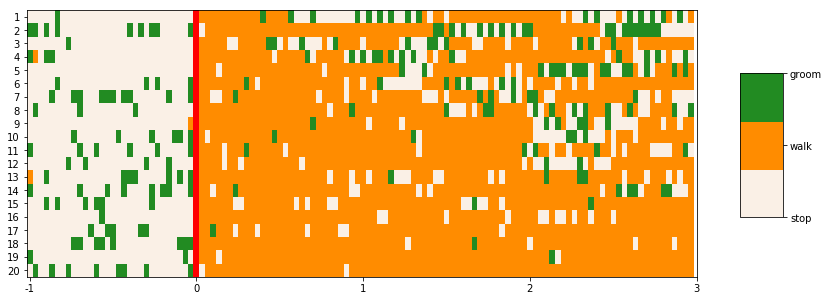

In [33]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
frame_start_stim = 30
frame_offset_analysis = 60
beh_cat_matrix = np.array(behaviour_classif_all_ordered)

fig,ax = plt.subplots(figsize=(12, 10))

#cmap = cm.get_cmap('jet',3)
cmap = ListedColormap(["linen","darkorange", "forestgreen"])

# tell imshow about color map so that only set colors are used
img = ax.imshow(beh_cat_matrix,cmap=cmap,interpolation='nearest')
ax.set_aspect(2.4)
ax.set_xticks(np.arange(0, 150, 30))
ax.set_xticklabels([-1, 0, 1, 2, 3,4])
ax.set_yticks(np.arange(0,20,1))
ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax.axvline(x=frame_start_stim, color='red', lw=6)
#ax.axvline(x=frame_offset_analysis, color='grey', lw=2, ls='--')

cbar_ax = fig.add_axes([0.95, 0.4, 0.05, 0.2])
# make a color bar
cbar = fig.colorbar(img, cax=cbar_ax, cmap=cmap, ticks=np.arange(3))
cbar.ax.set_yticklabels(['stop', 'walk', 'groom'])  # vertically oriented colorbar

plt.savefig('Rasterplot_sens37_unamp_ordered.svg')
plt.savefig('Rasterplot_sens37_unamp_ordered.png')

plt.show()

